# Pre-Processing TESS Light Curves

## Introduction

This processing pipeline was created using the [Identifying transiting exoplanet signals in a light curve tutorial from Lightkurve v2.0](http://docs.lightkurve.org/tutorials/3-science-examples/exoplanets-identifying-transiting-planet-signals.html). The tutorial has been modified to process TESS Light Curves for use with PyOrbit, so that they can be appropriately adjusted and saved in the correct format. The following example is for a system with three transiting planets, but identification of additional signals can be multiplied/removed where appropriate.

## Imports

In [1]:
import lightkurve as lk
from lightkurve import LightCurve
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.table import Table

## Downloading the Light Curve

Begin with searching for your target's TIC number, in this example we will be using the multi-planet system, TOI-270.

In [2]:
search_result = lk.search_lightcurve('TIC259377017')
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector,2018,DIAMANTE,1800,259377017,0.0
1,TESS Sector 03,2018,SPOC,120,259377017,0.0
2,TESS Sector 03,2018,TESS-SPOC,1800,259377017,0.0
3,TESS Sector 03,2018,QLP,1800,259377017,0.0
4,TESS Sector 04,2018,SPOC,120,259377017,0.0
5,TESS Sector 04,2018,TESS-SPOC,1800,259377017,0.0
...,...,...,...,...,...,...
9,TESS Sector 05,2018,QLP,1800,259377017,0.0
10,TESS Sector 30,2020,SPOC,20,259377017,0.0


Select a sector to download (TESS-SPOC has a 30min cadence and SPOC has a 2min cadence), for use with PyOrbit adjust the bjd values.

In [3]:
tlc = search_result[1].download() 
# tlc = search_result.download_all() to download multiple sectors
tlc['time'] += 7000 # adjust bjd values

Flatten the light curve.

Text(0.5, 0, 'Time - 2450000 [BTJD days]')

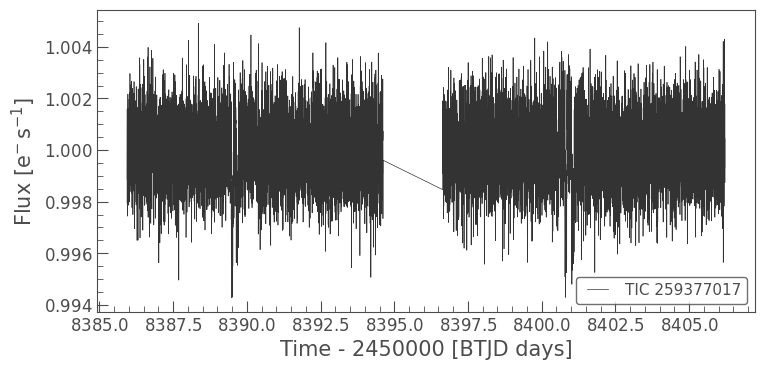

In [4]:
lc = tlc.flatten(window_length=901).remove_outliers() # use stitch. after tlc to stitch multiple sectors together
lc.plot();
plt.xlabel('Time - 2450000 [BTJD days]')

## The BLS Method for Finding Transiting Planets

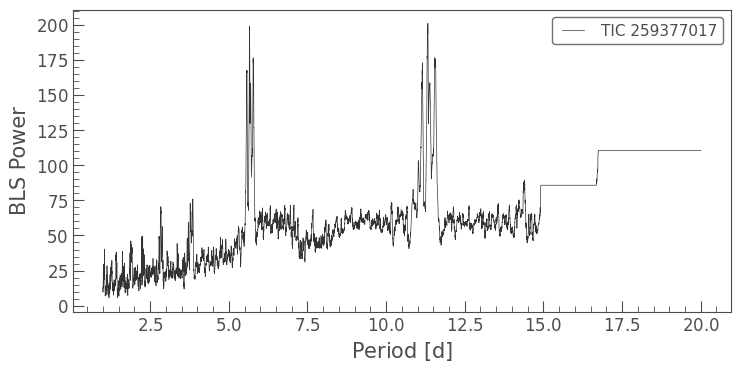

In [5]:
# Create array of periods to search
period = np.linspace(1, 20, 10000)
# Create a BLSPeriodogram
bls = lc.to_periodogram(method='bls', period=period, frequency_factor=500);
bls.plot();

The plot above shows the power, or the likelihood of the BLS fit, for each of the periods in the array we passed in. This plot shows a handful of high-power peaks at discrete periods, which is a good sign that a transit has been identified. The highest power spike shows the most likely period, while the lower power spikes are fractional harmonics of the period, for example, 1/2, 1/3, 1/4, etc.

We can pull out the most likely BLS parameters by taking their values at maximum power — we will refer to this transiting object as “planet b.”

In [6]:
planet_b_period = bls.period_at_max_power
planet_b_t0 = bls.transit_time_at_max_power
planet_b_dur = bls.duration_at_max_power

# Check the value for period
planet_b_period

<Quantity 11.32753275 d>

To confirm that this period and transit time (epoch) correspond to a transit signal, we can phase-fold the light curve using these values and plot it.

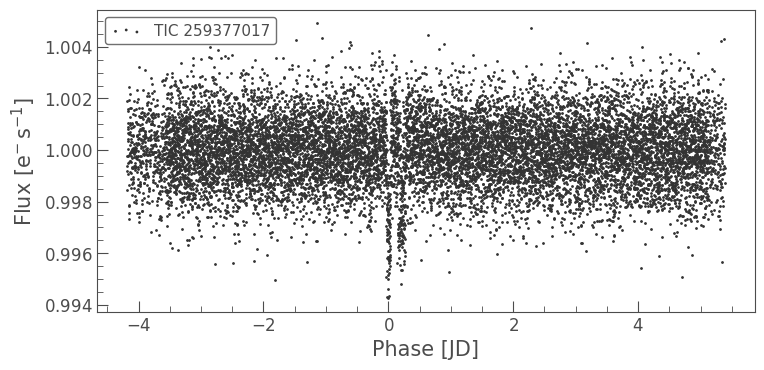

In [7]:
ax = lc.fold(period=planet_b_period, epoch_time=planet_b_t0).scatter()

## Retrieving a Transit Model and Cadence Mask

A cadence mask for the light curve can be created using the transit parameters from the BLS Periodogram

In [8]:
# Create a cadence mask using the BLS parameters
planet_b_mask = bls.get_transit_mask(period=planet_b_period,
                                     transit_time=planet_b_t0,
                                     duration=planet_b_dur)

Create a masled version of the light curve to search for additional transit signals. The light curve will plotted along with the masked cadences in red.

Text(0.5, 0, 'Time - 2450000 [BTJD days]')

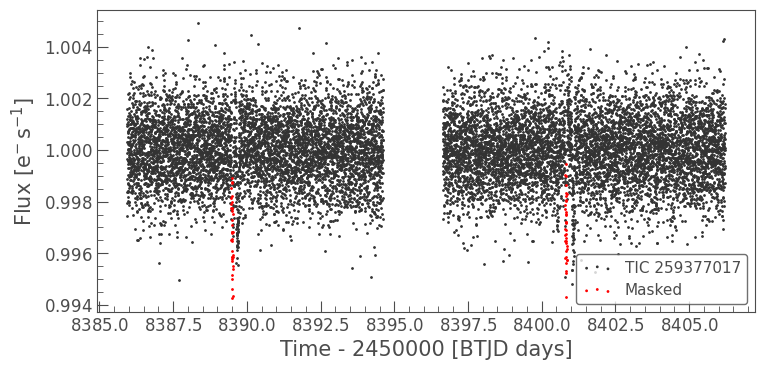

In [9]:
masked_b_lc = lc[~planet_b_mask]
ax = masked_b_lc.scatter();
lc[planet_b_mask].scatter(ax=ax, c='r', label='Masked');
plt.xlabel('Time - 2450000 [BTJD days]')

Then create a BLS model to visualize the transit fit. This returns a LightCurve object with the BLS model in the flux column.

In [10]:
# Create a BLS model using the BLS parameters
planet_b_model = bls.get_transit_model(period=planet_b_period,
                                       transit_time=planet_b_t0,
                                       duration=planet_b_dur)

Plot this model over the folded light curve to confirm that it accurately represents the transit.

<AxesSubplot:xlabel='Phase [JD]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

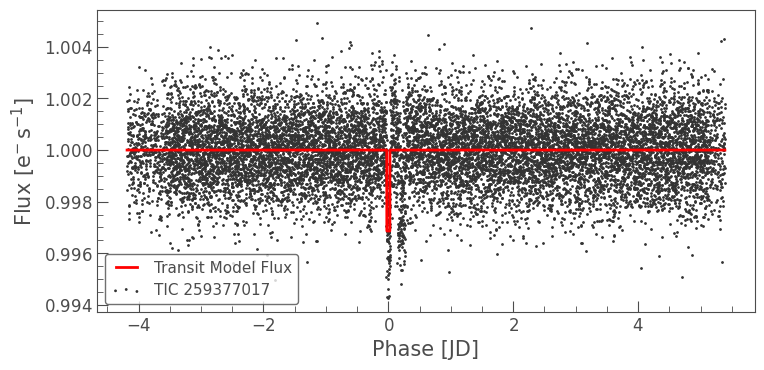

In [11]:
ax = lc.fold(planet_b_period, planet_b_t0).scatter()
planet_b_model.fold(planet_b_period, planet_b_t0).plot(ax=ax, c='r', lw=2)

## Identifying Additional Transiting Planet Signals in the Same Light Curve

The first identified planet has been masked out, now we can search the remaining light curve for additional transit signals. In this case we're searching for long-period planets, so the range of periods has been increased.

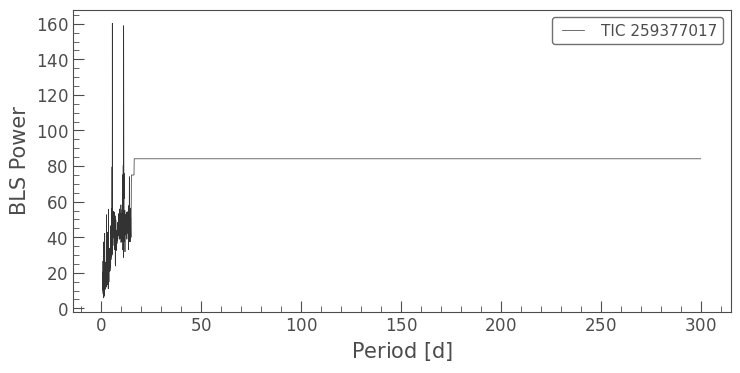

In [12]:
period = np.linspace(1, 300, 10000)
bls = masked_b_lc.to_periodogram('bls', period=period, frequency_factor=500)
bls.plot();

Look to see if there are any definite peaks from which the corresponding period and transit time can be pulled out to check the signal.

In [13]:
planet_c_period = bls.period_at_max_power
planet_c_t0 = bls.transit_time_at_max_power
planet_c_dur = bls.duration_at_max_power

# Check the value for period
planet_c_period

<Quantity 5.69476948 d>

Again plot the phase-folded light curve to examine the transit.

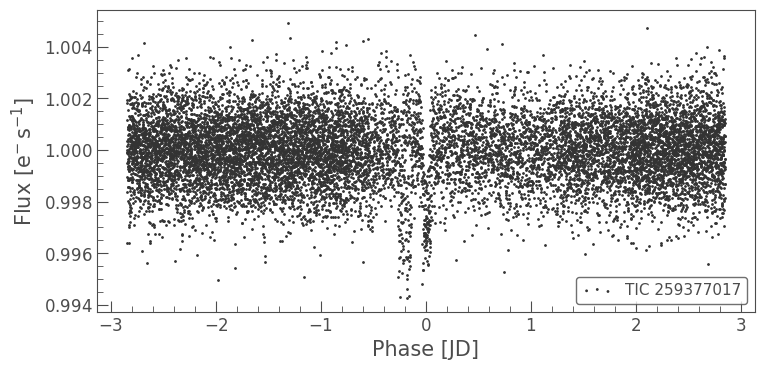

In [14]:
ax = lc.fold(period=planet_c_period, epoch_time=planet_c_t0).scatter()

Create a mask for this additional transiting planet.

In [15]:
# Create a cadence mask using the BLS parameters
planet_c_mask = bls.get_transit_mask(period=planet_c_period,
                                     transit_time=planet_c_t0,
                                     duration=planet_c_dur)

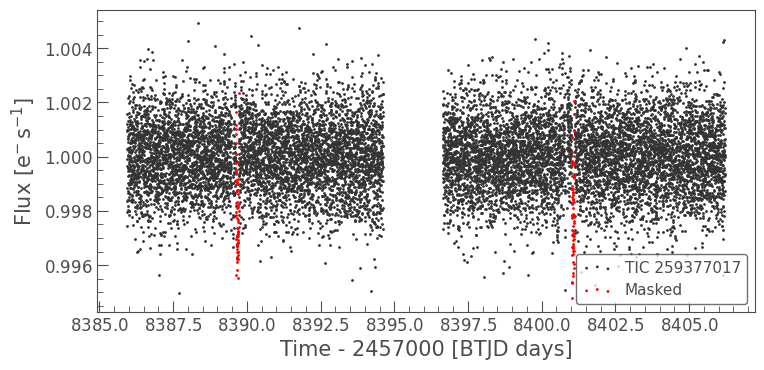

In [16]:
masked_c_lc = masked_b_lc[~planet_c_mask]
ax = masked_c_lc.scatter();
masked_b_lc[planet_c_mask].scatter(ax=ax, c='r', label='Masked');

Again create a BLS model to visualize the transit fit of the second transiting planet.

In [17]:
# Create a BLS model using the BLS parameters
planet_c_model = bls.get_transit_model(period=planet_c_period,
                                       transit_time=planet_c_t0,
                                       duration=planet_c_dur)

Use the 2 BLS models to visualize the transit timing in the light curve.

Text(0.5, 0, 'Time - 2450000 [BTJD days]')

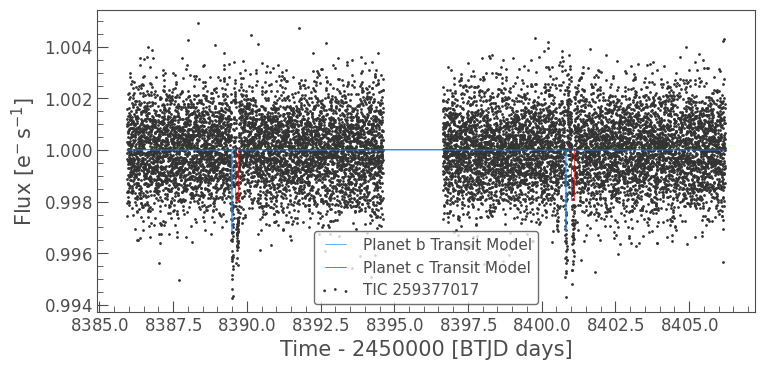

In [18]:
ax = lc.scatter();
planet_b_model.plot(ax=ax, c='dodgerblue', label='Planet b Transit Model');
planet_c_model.plot(ax=ax, c='r', label='Planet c Transit Model');
plt.xlabel('Time - 2450000 [BTJD days]')

## Identifying a Third Transiting Planet

Once again we create a periodogram with a relevant range of periods depending on the type of planet we hope to find. Then pull out the most likely BLS parameters by taking the values at maximum power. Then confirm that this period and transit time correspond to a transit signal by phase-folding the light curve and using the values to plot it.

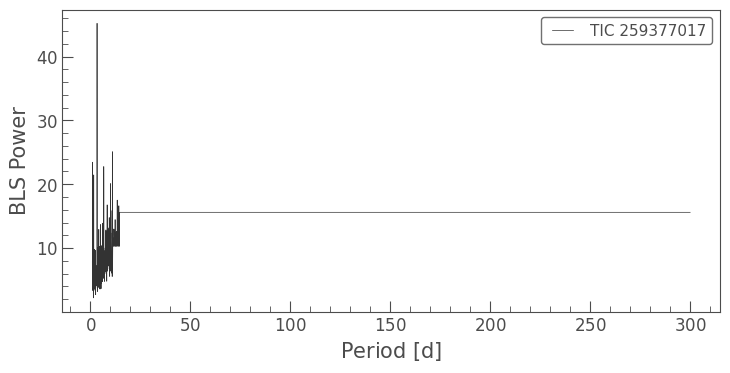

In [21]:
period = np.linspace(1, 300, 10000)
bls = masked_c_lc.to_periodogram('bls', period=period, frequency_factor=500)
bls.plot();

In [22]:
planet_d_period = bls.period_at_max_power
planet_d_t0 = bls.transit_time_at_max_power
planet_d_dur = bls.duration_at_max_power

# Check the value for period
planet_d_period

<Quantity 3.36233623 d>

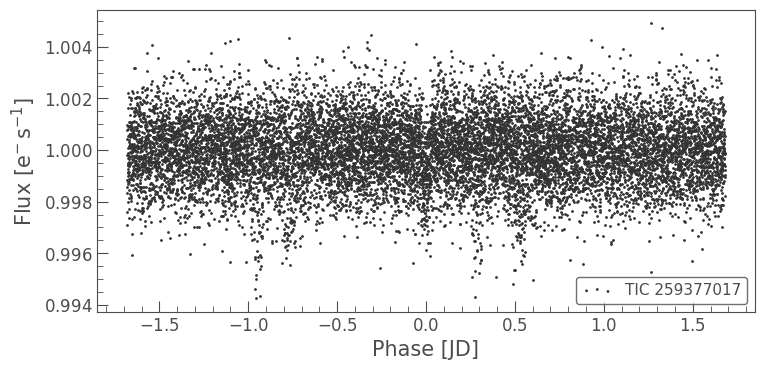

In [23]:
ax = lc.fold(period=planet_d_period, epoch_time=planet_d_t0).scatter()

Finally we can once again create a masked version of the lightcurve in the case where we may want all transiting signals removed from the lightcurve. Then a BLS model can be created to visualise the transit fit.

In [28]:
# Create a cadence mask using the BLS parameters
planet_d_mask = bls.get_transit_mask(period=planet_d_period,
                                     transit_time=planet_d_t0,
                                     duration=planet_d_dur)

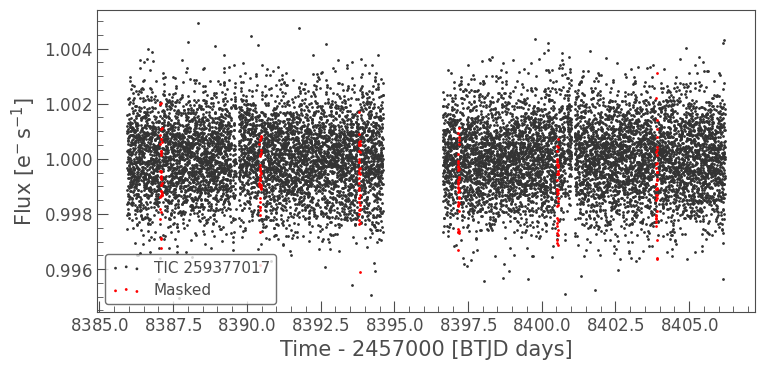

In [29]:
masked_d_lc = masked_c_lc[~planet_d_mask]
ax = masked_d_lc.scatter();
masked_c_lc[planet_d_mask].scatter(ax=ax, c='r', label='Masked');
plt.xlabel('Time - 2450000 [BTJD days]');

In [30]:
# Create a BLS model using the BLS parameters
planet_d_model = bls.get_transit_model(period=planet_d_period,
                                       transit_time=planet_d_t0,
                                       duration=planet_d_dur)

We have now succesfully identified three planets in the same system! We can use the BLS models to visualize the transit timing in the light curve.

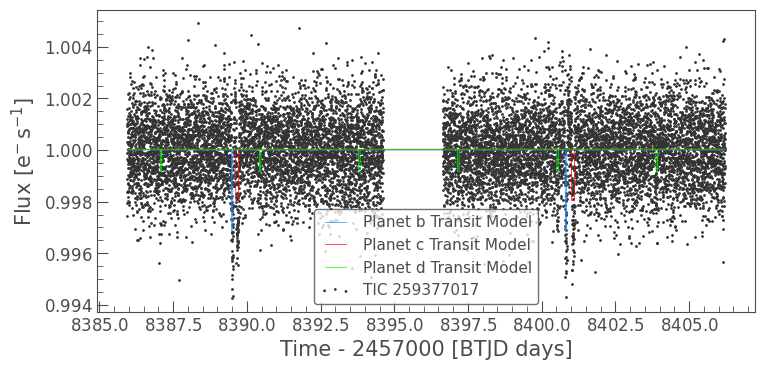

In [27]:
ax = lc.scatter();
planet_b_model.plot(ax=ax, c='dodgerblue', label='Planet b Transit Model');
planet_c_model.plot(ax=ax, c='r', label='Planet c Transit Model');
planet_d_model.plot(ax=ax, c='lime', label='Planet d Transit Model');
plt.xlabel('Time - 2450000 [BTJD days]');

## Binning the Light Curve

PyOrbit only works with files up to a certain size limit, so if there are a lot of data points (>>1000) it's best to bin the data points. In the case of author=SPOC it's best to bin the data points every 30 minutes.

Text(0.5, 0, 'Time - 2450000 [BTJD days]')

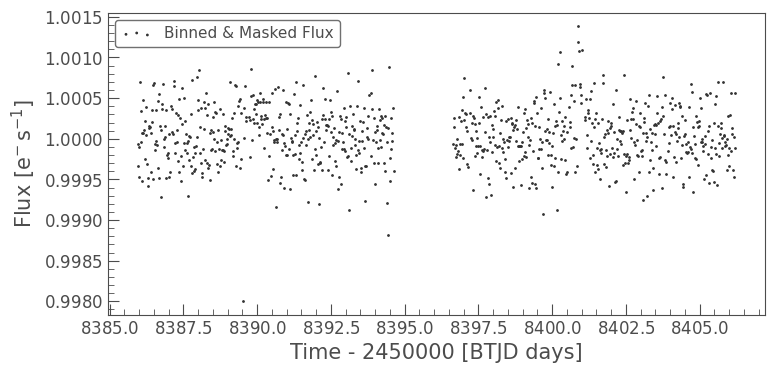

In [31]:
tlc_binmasked = masked_d_lc.bin(.02) # binned every 30 minutes
tlc_binmasked.scatter(label='Binned & Masked Flux')
plt.xlabel('Time - 2450000 [BTJD days]')

## Saving and Formatting the File

First save as a .fits file using the Lightkurve function.

In [ ]:
tlc_binmasked.to_fits(path='TOI270_TESS_mbc_LC.fits', overwrite=True)

Create an array of -1's so the file can be compatabile with PyOrbit. Remember to change the length of the array to the length of the .fits file.

In [ ]:
mat=np.ones((1014,1)) # create -1 array for remaining columns
jitter = -mat
int_array = jitter.astype(int) # convert from float array to integers

Read in .fits file, drop the unneeded columns and add the 2 columns of -1's.

In [ ]:
dat = Table.read('TOI270_TESS_mbc_LC.fits', format='fits')
df = dat.to_pandas()
df = df.drop(['MOM_CENTR1', 'MOM_CENTR2'], axis=1)
df = df.assign(extra1=int_array)
df = df.assign(extra2=int_array)

Display the final table to check everything is in order.

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

Convert to .dat file and save. The file will save in the same folder as this notebook.

In [ ]:
df.to_csv('TOI270_TESS_mbc_LC.dat',index=False,header=False, sep=' ')